# DTSA - 5511 Deeplearning - Week 3 Kaggle Challenge
## Histopathologic Cancer Detection
### https://www.kaggle.com/c/histopathologic-cancer-detection/overview

This notebook contains the code for the Week 3 mini-project Histopathologic Cancer Detection from Kaggle.

The objective of the project is to detect Metastasis for Histopathologic Cancer, in the given dataset of input images. This will be treated as a binary classification problem,

#### From the Kaggle Project dataset description

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

#### STEP 1 : Copy and Unzip files from Google drive

In [5]:
# Complete path to storage location of the .zip file of data
# Mount google drive
import os
from google.colab import drive
drive.mount('/gdrive')

zip_path = '/gdrive/MyDrive/kaggle/histopathologic-cancer-detection.zip'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
print(os.getcwd())
# Copy the .zip file into the present directory
!cp '{zip_path}' .
# Unzip quietly
!unzip -q 'histopathologic-cancer-detection.zip'
# View the unzipped contents in the virtual machine
os.listdir()

Mounted at /gdrive
/content


['.config',
 'sample_submission.csv',
 'train',
 'test',
 'train_labels.csv',
 'histopathologic-cancer-detection.zip',
 'sample_data']

#### STEP 2: Import all required libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as k

## Exploratory Data Analysis

In [7]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Read the Training labels

In [8]:
train = pd.read_csv('./train_labels.csv', dtype=str)
print(train.shape)

(220025, 2)


In [9]:
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [10]:
train.id = train.id + '.tif'

train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [11]:
(train.label.value_counts() / len(train)).to_frame().sort_index().T

label,0,1
count,0.594969,0.405031


### Extract some sample images from the training set

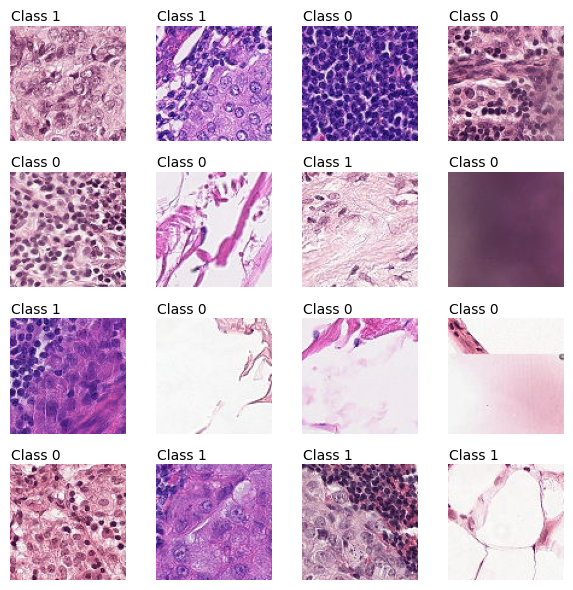

In [12]:
train_path = "./train"

sample = train.sample(n=16).reset_index()

plt.figure(figsize=(6,6))

for i, row in sample.iterrows():

    img = mpimg.imread(f'./train/{row.id}')
    label = row.label

    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')

    plt.axis('off')

plt.tight_layout()
plt.show()

### Split training set for validation

In [13]:
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=1, stratify=train.label)

In [14]:
print(train_df.shape)
print(valid_df.shape)
train_df.head()

(176020, 2)
(44005, 2)


,id,label
169632,05afcb247924970d9c7c17ccf956db20f8b626f3.tif,0
48553,55e47dbf379817bf65ba25ac599a639638a44bbb.tif,0
165988,836b2171417da27f68be363c80fd53e0319f875f.tif,1
48724,8ff04d223f6ce6d707565e9cf19ca4f040e6b8d5.tif,0
173841,af80e9b4701f43eb0354dc58088186a1a76f897a.tif,1


### Generate image data using keras image library function ImageDataGenerator


In [15]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

In [16]:
BATCH_SIZE = 128

#### Load the train dataset into the ImageDataGenerator
#### Initially we choose a target size of 96,96,3 (1/2 of the original image)

train_loader = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)

#### Load the valid dataset into the ImageDataGenerator

valid_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96,96)
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [17]:
print(len(train_loader))
print(len(valid_loader))

1376
344


In [18]:
print(valid_loader[0][0].shape)

(128, 96, 96, 3)


## Build the Sequential model and add the convolutional layers
---




In [19]:
np.random.seed(1)
tf.random.set_seed(1)
model = keras.Sequential(name='nn')
model.add(layers.Conv2D(32, 3, activation="relu", padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Conv2D(64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation='softmax'))
model.build(input_shape=valid_loader[0][0].shape)

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (128, 96, 96, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2  (128, 48, 48, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (128, 46, 46, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (128, 23, 23, 64)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (128, 33856)              0         
                                                                 
 dense (Dense)               (128, 2)                  67714    

In [21]:

model.fit(train_loader,steps_per_epoch=100, epochs=10, validation_data=valid_loader, validation_steps=len(valid_loader)/128)

Epoch 1/10
100/100 [==============================] - 40s 338ms/step - loss: 0.6439 - accuracy: 0.6209 - val_loss: 0.5242 - val_accuracy: 0.7760
Epoch 2/10
100/100 [==============================] - 32s 319ms/step - loss: 0.4838 - accuracy: 0.7783 - val_loss: 0.4772 - val_accuracy: 0.7708
Epoch 3/10
100/100 [==============================] - 28s 281ms/step - loss: 0.4731 - accuracy: 0.7816 - val_loss: 0.4456 - val_accuracy: 0.7995
Epoch 4/10
100/100 [==============================] - 25s 254ms/step - loss: 0.4615 - accuracy: 0.7902 - val_loss: 0.4907 - val_accuracy: 0.7682
Epoch 5/10
100/100 [==============================] - 24s 238ms/step - loss: 0.4574 - accuracy: 0.7903 - val_loss: 0.4763 - val_accuracy: 0.7786
Epoch 6/10
100/100 [==============================] - 22s 218ms/step - loss: 0.4495 - accuracy: 0.7948 - val_loss: 0.4560 - val_accuracy: 0.7812
Epoch 7/10
100/100 [==============================] - 22s 224ms/step - loss: 0.4568 - accuracy: 0.7911 - val_loss: 0.4932 - val_ac